In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

In [2]:
arquivo = "movies.csv" 
data = pd.read_csv(arquivo, sep = '\t') 
type(data)

pandas.core.frame.DataFrame

In [3]:
data.head()

,UserID,ItemID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
data.shape

(100000, 4)

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

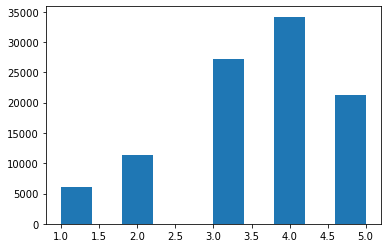

In [5]:
# Distribuição dos Ratings
plt.hist(data['Rating'])

In [6]:
data.groupby(['Rating'])['UserID'].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

In [7]:
# Criando a variável n_users para encontrar o número total de usuários únicos
n_users = data.UserID.unique().shape[0] 

In [8]:
# Criando a variável n_items para encontrar o número total de filmes únicos
n_items = data.ItemID.unique().shape[0] 

In [9]:
# Print
print(str(n_users) + ' usuários') 
print(str(n_items) + ' filmes') 

943 usuários
1682 filmes


In [10]:
# Cria uma matriz de zeros com tamanho (n_users X n_items) para armazenar os ratings nas células
ratings = np.zeros((n_users, n_items)) 

In [11]:
# Para cada registro do dataset, extrair a informação de cada coluna de cada linha e armazenar na matriz de ratings
for  row in data.itertuples():
  ratings[row[1]-1, row[2]-1] = row[3] 

In [12]:
type(ratings)

numpy.ndarray

In [13]:
ratings.shape

(943, 1682)

In [14]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [15]:
# Calculando a esparsidade da matriz
# Esse resultado significa que temos apenas 6.3% de ratings neste conjunto de dados e que todo o 
# resto está preenchido com zeros (esses zeros NÃO representam ratings e sim valores missing)
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100 
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


In [16]:
# Criando conjunto de dados de treino e de teste para treinar o motor de recomendação
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.33, random_state = 42)
ratings_test.shape

(312, 1682)

### User Based Colaborative Filtering (UBCF)

In [17]:
# Calculando a matriz de distâncias com: cosine_distances(ratings_train)
dist_out = 1 - cosine_distances(ratings_train)

In [18]:
type(dist_out)

numpy.ndarray

In [19]:
dist_out.shape

(631, 631)

In [20]:
dist_out

array([[1.        , 0.36475764, 0.44246231, ..., 0.02010641, 0.33107929,
        0.25638518],
       [0.36475764, 1.        , 0.42635255, ..., 0.06694419, 0.27339314,
        0.22337268],
       [0.44246231, 0.42635255, 1.        , ..., 0.06675756, 0.25424373,
        0.22320126],
       ...,
       [0.02010641, 0.06694419, 0.06675756, ..., 1.        , 0.04853428,
        0.05142508],
       [0.33107929, 0.27339314, 0.25424373, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.25638518, 0.22337268, 0.22320126, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [21]:
# Prevendo os ratings
# Isso é feito através da multiplicação da matriz de distâncias com a matriz de ratings
user_pred = dist_out.dot(ratings_train) / np.array([np.abs(dist_out).sum(axis=1)]).T

In [22]:
user_pred

array([[2.46573349, 0.82987753, 0.46745119, ..., 0.        , 0.01051423,
        0.00930566],
       [2.20129624, 0.5513313 , 0.44342882, ..., 0.        , 0.00682653,
        0.00629833],
       [2.23857808, 0.68874746, 0.45178516, ..., 0.        , 0.00863713,
        0.0084224 ],
       ...,
       [1.74346476, 0.40503715, 0.32435436, ..., 0.        , 0.00284126,
        0.0094319 ],
       [2.32393481, 0.81386209, 0.48334765, ..., 0.        , 0.01058346,
        0.01011386],
       [2.35304498, 0.59746852, 0.38845057, ..., 0.        , 0.00669755,
        0.00562433]])

In [23]:
# Função para obter as métricas
# Usaremos o MSE (Mean Square Error) para avaliar os erros comparando valores atuais e valores previstos
# Quanto menor, melhor!
def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [24]:
# Avaliando as previsões nos dados de treino
get_mse(user_pred, ratings_train)

7.882193991551003

In [25]:
# Avaliando as previsões nos dados de teste
get_mse(user_pred, ratings_test)

8.922495431696548

Os valores dos erros acima estão muito altos. Precisamos fazer algo para tentar reduzir os erros nas previsões deste motor de recomendações. Por que não tentar Machine Learning?

A provável causa do valor alto para os erros, pode ter sido o fato de usarmos todos os ratings em nossos cálculos. Vamos agora usar apenas os "top 5 usuários similares" enquanto estivermos preparando nossas previsões.

In [26]:
# Definindo o valor de k para o top 5
k = 5

Vamos usar o modelo KNN. Vamos usar uma medida de similaridade (cosine) para encontrar o "top 5 usuários similares".

In [27]:
# Definir o objeto NearestNeighbors passando k como parâmetro e definindo o método de similaridade para criar o modelo
modelo = NearestNeighbors(k,'cosine')

In [28]:
# Fit dos dados de treino no modelo
modelo.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius='cosine')

In [29]:
# Extraindo os usuários top 5 em similaridade
top_k_distances, top_k_users = modelo.kneighbors(ratings_train, return_distance = True)

In [30]:
top_k_distances.shape

(631, 5)

In [31]:
top_k_users.shape

(631, 5)

In [32]:
top_k_users[0]

array([  0,  82, 511, 184, 207], dtype=int64)

In [33]:
# Preparando a matriz de zeros
user_pred_k = np.zeros(ratings_train.shape)

In [34]:
# Fazendo as previsões
for i in range(ratings_train.shape[0]):
  user_pred_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [35]:
user_pred_k.shape

(631, 1682)

In [36]:
user_pred_k

array([[3.25379713, 1.75556855, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.48370298, 0.        , 1.24948776, ..., 0.        , 0.        ,
        0.        ],
       [1.01011767, 0.73826825, 0.7451635 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74469557, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.9753676 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [37]:
get_mse(user_pred_k, ratings_train)

8.195606511453878

In [38]:
get_mse(user_pred_k, ratings_test)

11.602073790588975